# Image classification with multilayer perceptron (MLP)

In this lab we design and train our first MLP network, and we use it for image classification.

In [169]:
import torch 
import torchvision
from torch.utils.data import DataLoader, random_split, Subset
import torch.nn as nn
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import random
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
import copy

## Dataset

We use the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset, which is a large image dataset of hand-written digits.

<center><a href="https://en.wikipedia.org/wiki/MNIST_database">
    <img src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png"></a></center>

Just like some other widely-used datasets, MNIST can be downloaded directly from Pytorch, and includes specific commands to create a `Dataset` object, thus you don't have to do it manually as we did in lab 1.

In [170]:
# Define the data repository
data_dir = 'data/'

# Choose one (or several) transform(s) to preprocess the data
# Here, we transform it to torch tensors, and we apply some normalization
data_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize((0.1307,), (0.3081,))])

# Create a Dataset (you can download the data by setting 'download=True')
train_data = torchvision.datasets.MNIST(data_dir, train=True, download=True, transform=data_transforms)
test_data = torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=data_transforms)
num_classes = len(train_data.classes)
print('Number of classes in the dataset:', num_classes)

# We are not going to work with the full dataset (which is quite large), so we only keep small train and test subsets.
train_data = Subset(train_data, torch.arange(400))
test_data = Subset(test_data, torch.arange(50))
print('Number of images in the train dataset', len(train_data))
print('Number of images in the test dataset', len(test_data))

Number of classes in the dataset: 10
Number of images in the train dataset 400
Number of images in the test dataset 50


torch.Size([1, 28, 28])
Image label= 5


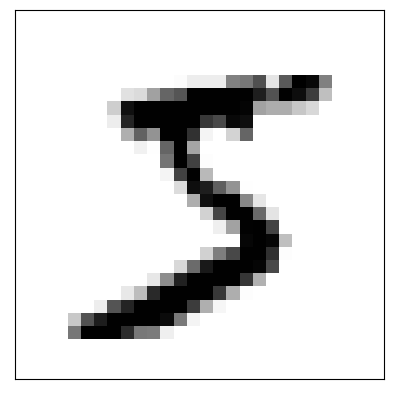

In [171]:
# Fetch one data pair (one image and the corresponding label)
image, label = train_data[0]
print(image.shape)
print('Image label=', label)

# The size of the image is [1, 28, 28], which corresponds to [num_channels, height, width]
# Indeed, MNIST images are in black-and-white (or grey scale) so there is only 1 color channel.
# To plot this image, let's remove this channel dimension by using squeeze()
plt.figure()
plt.imshow(image.squeeze(), cmap='gray_r')
plt.xticks([]), plt.yticks([])
plt.show()

In [172]:
# TO DO:
# - create two dataloaders (for the training and testing subsets) with a batch size of 8
# Batch size
batch_size = 8

# Create DataLoader for training subset
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

# Create DataLoader for testing subset
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)
# - print the number of batches in the training subset
print(len(train_dataloader))

50


In [173]:
# Get a batch of images and corresponding labels from the train dataloader
batch_example = next(iter(train_dataloader))
image_batch_example = batch_example[0]
labels_batch_example = batch_example[1]

# Print the size of the batch of images and labels
print(image_batch_example.shape)
print(labels_batch_example.shape)

torch.Size([8, 1, 28, 28])
torch.Size([8])


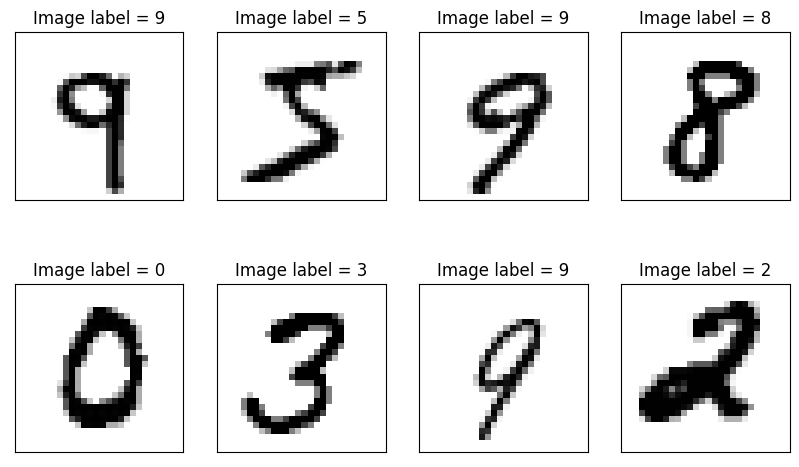

In [174]:
# Plot the images in the batch (along with the corresponding label)
plt.figure(figsize = (10,6))
for ib in range(batch_size):
    plt.subplot(batch_size // 4, 4, ib+1)
    plt.imshow(image_batch_example[ib, :].squeeze(), cmap='gray_r')
    plt.xticks([]), plt.yticks([])
    plt.title('Image label = ' + str(labels_batch_example[ib].item()))
plt.show()

## MLP network

A typical MLP network is composed of several layers:

- an *input* layer, which takes a batch of vectors and computes the first hidden representation.
- one or several *hidden* layers.
- an *output* layer, which computes the output of the network.

Each layer consists of a linear part and a non-linear *activation* functions (remember lab 2). There are many non-linear activation functions in Pytorch, check the [documentation](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) for a complete overview. A network is said to be *deep* if it has at least 3 layers (input, at least one hidden, and output).

<center><a href="https://www.researchgate.net/publication/309592737_Classification_of_VoIP_and_non-VoIP_traffic_using_machine_learning_approaches">
    <img src="https://www.researchgate.net/profile/Mouhammd-Alkasassbeh/publication/309592737/figure/fig2/AS:423712664100865@1478032379613/MultiLayer-Perceptron-MLP-sturcture-334-MultiLayer-Perceptron-Classifier-MultiLayer.png"></a></center>

**Note**: Since an MLP manipulates vectors (= 1D-tensors) as inputs, in image processing we first have to transform our images into vectors. For instance, if a black-and-white image is a (3D) tensor of size `[1, 28, 28]`, then we have to reshape it into a tensor of size `[1x28x28] = [784]`.


### Example

First, let's write each layer individually and apply them on the example batch `image_batch_example`.

In [175]:
# TO DO: reshape image_batch_example into a batch of vectors (=vectorized images):
# 'image_batch_example' has size [batch_size, 1, 28, 28]
# 'vectorized_batch' should have size [batch_size, 1*28*28]
# Reshape the image batch to vectors
vectorized_batch = image_batch_example.view(batch_size, -1)

In [176]:
# Now we create the input layer (linear and activation) and we pass the vectorized batch through it
input_size = vectorized_batch.shape[-1]
hidden_size = 10
input_layer = nn.Sequential(nn.Linear(input_size, hidden_size), nn.Sigmoid())
y = input_layer(vectorized_batch)
print(y.shape)

torch.Size([8, 10])


Now, let's create the hidden and output layers.
- the hidden layer goes from `hidden_size` to `hidden_size`, and uses a Sigmoid activation function.
- the output layer goes from `hidden_size` to `output_size`, and uses no activation function.

**Note**: the output size is the number of classes in the dataset.

In [177]:
# TO DO:
# Define the sizes of the layers
# hidden_size = 10
output_size = 10   # Example output layer size

# Create a feedforward neural network using nn.Sequential
model = nn.Sequential(
    nn.Linear(hidden_size, hidden_size),  # Hidden layer with hidden_size input and hidden_size output
    nn.Sigmoid(),                         # Sigmoid activation function for the hidden layer
    nn.Linear(hidden_size, output_size)   # Output layer with hidden_size input and output_size output
)

# You can print the model to see its architecture
print(model)
# - apply them to y to compute the output 'out'
out = model(y)
# - print the size of 'out'
print(out.shape)


Sequential(
  (0): Linear(in_features=10, out_features=10, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=10, out_features=10, bias=True)
)
torch.Size([8, 10])


From what we have done above, two important remarks can be made:

- The output `out` has size `[batch_size, num_classes]` while the true labels `labels_batch_example` has size `[batch_size]`. This is because `out` contains a predicted probability for each class, while `labels_batch_example` simply contains the true labels.
- In classification tasks, we want to output *probabilities per class*. However, nothing ensures that `out` corresponds to probabilities, since it is not normalized and we didn't use any output activation function (values can be negative and not sum up to 1).

However, when training a classification network, we generally use the [Cross Entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) loss function, which alleviates these two issues. This loss is optimized for handling true labels instead of true probabilities per class, so you don't have to worry about it. Besides, it will automatically apply a [Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) non-linearity to the predicted outputs, in order to normalize them as probabilities per class.

**Note**: Instead of Cross Entropy, you can use the [Negative log-likelihood](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss) similarly. It will also solve the first problem, but then you need to manually add a [log Softmax](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html#torch.nn.LogSoftmax) as output activation to normalize the outputs.

In [178]:
# Choose Cross Entropy as loss function
loss_fn = nn.CrossEntropyLoss()

# Compute the error between the predicted labels 'out' and true labels 'labels_batch_example'
loss_batch = loss_fn(out, labels_batch_example)
print(loss_batch.item())

2.1895434856414795


### General module

Now, let's create a general MLP classification network. It's a python class that inherits from the general `nn.Module` object, and it should contain at least 2 methods:

- `__init__`, which initializes the network when instanciated (creates all the layers and stores some useful parameters if needed).
- `forward`, which applies the forward pass (i.e., applies the layers to the input in order to compute the output).

You can add other methods if needed but these two are sufficient for now.

**Note**: Remember that Python classes usually define and use some variables/data/tensors/dictionary etc. internally (this includes network layers) called *attributes*: they should be defined in the `__init__` method with a specific structure (the name should start by `self.`, as we did in lab 1). This allows you to access these attributes in other methods, or after defining your network.

In [179]:
class MLPClassif(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, act_fn):
        super(MLPClassif, self).__init__()
        
        # TO DO: define the input, hidden, and output layers as before
        self.model = nn.Sequential(
                     nn.Linear(input_size, hidden_size),   # Input layer with inpt_size for the hidden_size output
                     act_fn,                               # Activation function for the input layer
                     nn.Linear(hidden_size, hidden_size),  # Hidden layer with hidden_size input and hidden_size output
                     act_fn,                               # Activation function for the hidden layer
                     nn.Linear(hidden_size, output_size)   # Output layer with hidden_size input and output_size output
        )


    def forward(self, x):

        # TO DO: write the 'forward' method, which computes the output 'out' from the input x
        # It should apply the input, hidden, and output layer, as we did in the example before.
        out = self.model(x)
        return out

In [180]:
# TO DO: Instanciate an MLP classifier with a hidden size of 10 and a Sigmoid activation function
model= MLPClassif(input_size, 10, output_size, nn.Sigmoid())
print(model)

MLPClassif(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=10, out_features=10, bias=True)
  )
)


In [181]:
# initialization (ensure reproducibility: everybody should have the same results)
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    return

torch.manual_seed(0)
model.apply(init_weights)

MLPClassif(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [182]:
# You can save / load the model's parameters as follow:
torch.save(model.state_dict(), 'model_mlp_classif.pt')
model.load_state_dict(torch.load('model_mlp_classif.pt'))

<All keys matched successfully>

In [183]:
# A useful command to get the total number of parameters in the model
print('Total number of parameters:', sum(p.numel() for p in model.parameters()))

Total number of parameters: 8070


<span style="color:red">**Q1**</span> How many parameters are in the network?

## Training

We now write the function for training the network. It's very similar to what we did in lab 2, except now we process batches of data instead of the whole dataset at each epoch.

In [184]:
def training_mlp_classifier(model, train_dataloader, num_epochs, loss_fn, learning_rate, verbose=True):

    # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)
    
    # Set the model in 'training' mode (ensures all parameters' gradients are computed - it's like setting 'requires_grad=True' for all parameters)
    model_tr.train()
    
    # Define the optimizer
    optimizer = torch.optim.SGD(model_tr.parameters(), lr=learning_rate)
    
    # Initialize a list for storing the training loss over epochs
    train_losses = []
    
    # Training loop
    for epoch in range(num_epochs):
        
        # Initialize the training loss for the current epoch
        tr_loss = 0
        
        # Iterate over batches using the dataloader
        for batch_index, (images, labels) in enumerate(train_dataloader):
            
            # TO DO: write the training procedure for each batch. This should consist of:
            # - vectorizing the images (size should be (batch_size, input_size))
            vectorized_batch = images.view(batch_size, input_size)
            # - calculate the predicted labels from the vectorized images using 'model_tr'
            labels_pred = model_tr(vectorized_batch)
            # - using loss_fn, calculate the 'loss' between the predicted and true labels
            l = loss_fn(labels_pred, labels)
            tr_loss = tr_loss + l.item()
            # - set the optimizer gradients at 0 for safety
            optimizer.zero_grad()
            # - compute the gradients (use the 'backward' method on 'loss')
            l.backward()
            # - apply the gradient descent algorithm (perform a step of the optimizer)
            optimizer.step()
            
        # At the end of each epoch, get the average training loss and store it
        tr_loss = tr_loss/len(train_dataloader.dataset)
        train_losses.append(tr_loss)
        
        # Display the training loss
        if verbose:
            print('Epoch [{}/{}], Training loss: {:.4f}'.format(epoch+1, num_epochs, tr_loss))
    
    return model_tr, train_losses

In [185]:
# TO DO: Define the training parameters and train the model
# - 30 epochs
num_epochs = 30
# - learning rate = 0.01
learning_rate = 0.01
# - loss function: Cross Entropy
loss_fn = torch.nn.CrossEntropyLoss()
# - training
model_tr, trainlosses = training_mlp_classifier(model,train_dataloader,num_epochs, loss_fn, learning_rate, verbose=True)
# After training, save the model parameters and display the loss over epochs
torch.save(model_tr.state_dict(), 'model_params.pth')

## Evaluation

Now the model is trained, we can evaluate it on the test dataset. We do that by predicting the labels using our model, and comparing it with the true labels. This allows us to compute the classification accuracy, which is provided in the function below.

In [186]:
# Evaluation function: similar to the training loop, except we don't need to compute any gradient / backprop

def eval_mlp_classifier(model, eval_dataloader):
    
    # Set the model in 'evaluation' mode (this disables some layers (batch norm, dropout...) which are not needed when testing)
    model.eval() 

    # In evaluation phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        correct_labels = 0
        total_labels = 0
        
        # Iterate over the dataset using the dataloader
        for images, labels in eval_dataloader:

            # Get the predicted labels
            images = images.reshape(images.shape[0], -1)
            y_predicted = model(images)
            
            # To get the predicted labels, we need to get the max over all possible classes
            _, label_predicted = torch.max(y_predicted.data, 1)
            
            # Compute accuracy: count the total number of samples, and the correct labels (compare the true and predicted labels)
            total_labels += labels.size(0)
            correct_labels += (label_predicted == labels).sum().item()
    
    accuracy = 100 * correct_labels / total_labels
    
    return accuracy

68.0


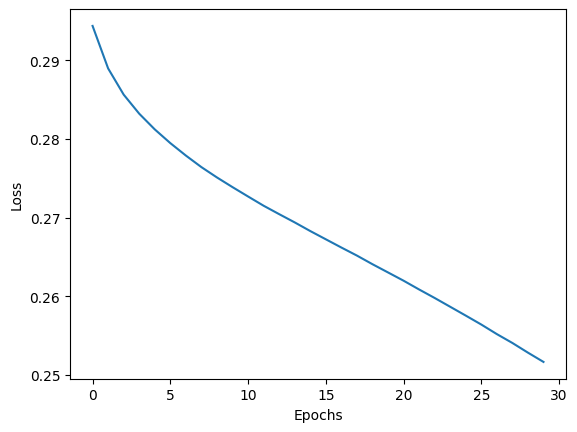

In [187]:
# TO DO: Evaluate the model on the test set:
# - Instanciate an MLP newtork and load the trained parameters
model_tr, trainlosses = training_mlp_classifier(model,train_dataloader,num_epochs, loss_fn, learning_rate, verbose=True)
# - Apply the evaluation function using the test dataloader
eval = eval_mlp_classifier(model_tr,test_dataloader)
# - Print the test accuracy
print(eval)
plt.figure()
plt.plot(trainlosses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

<span style="color:red">**Q2**</span> Put the plot above (training loss over epochs) and the test accuracy in your report. Based on the plot, can you suggest a way to improve the test accuracy?

## Influence of the activation function

We used the MLP classifier with a Sigmoid activation function, but another common choice is the [Rectified Linear Unit](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu#torch.nn.ReLU). Here we investigate how it performs compared to the Sigmoid-based network.

In [188]:
# TO DO: Define an MLP classifier using a ReLU activation. 
model_relu = MLPClassif(input_size, hidden_size, num_classes, nn.ReLU())

In [189]:
# Initialize the weights (for reproducibility)
torch.manual_seed(0)
model_relu.apply(init_weights)

MLPClassif(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
  )
)

90.0


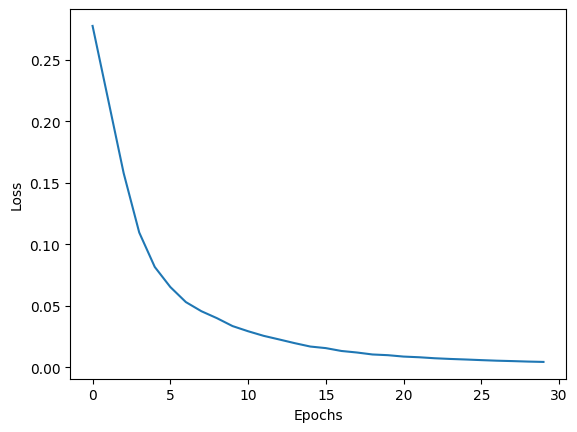

In [190]:
# TO DO: Train the network and evaluate it.
model_tr, trainlosses = training_mlp_classifier(model_relu,train_dataloader,num_epochs, loss_fn, learning_rate, verbose=True)
eval = eval_mlp_classifier(model_tr,test_dataloader)
print(eval)
plt.figure()
plt.plot(trainlosses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

<span style="color:red">**Q3**</span> What is the accuracy on the test set with this network? Which one (Sigmoid or ReLU) would you recommend to use?

## Increasing the model capacity

In order to improve performance, a straightforward approach is to increase the model capacity, i.e., increase the number of parameters. There are basically two ways to do so: either increase the number of neurons in each layer (*width*) of increase the total number of layers (*depth*). Let's focus here on width.


Hidden size= 5 --Total number of parameters: 4015  -- Test accuracy: 58.0 %


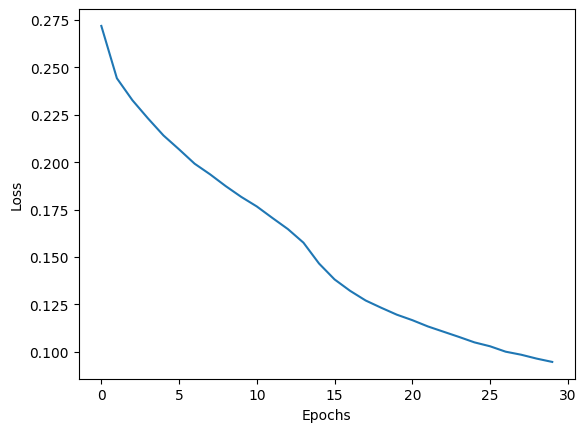


Hidden size= 10 --Total number of parameters: 8070  -- Test accuracy: 90.0 %


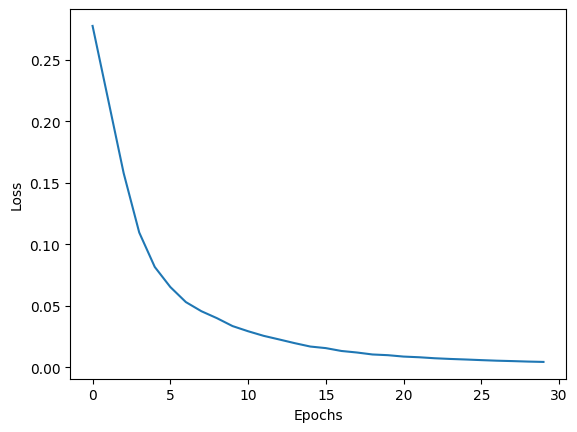


Hidden size= 100 --Total number of parameters: 89610  -- Test accuracy: 90.0 %


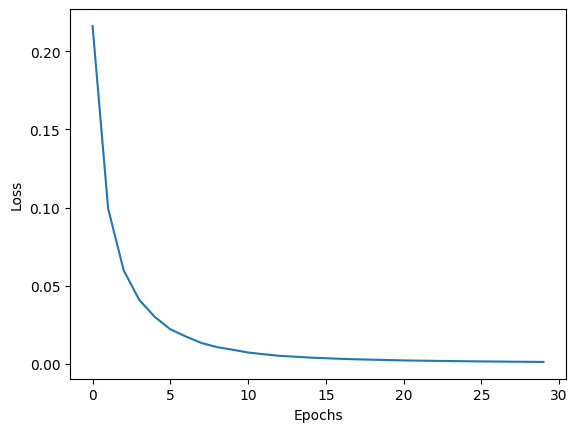


Hidden size= 200 --Total number of parameters: 199210  -- Test accuracy: 86.0 %


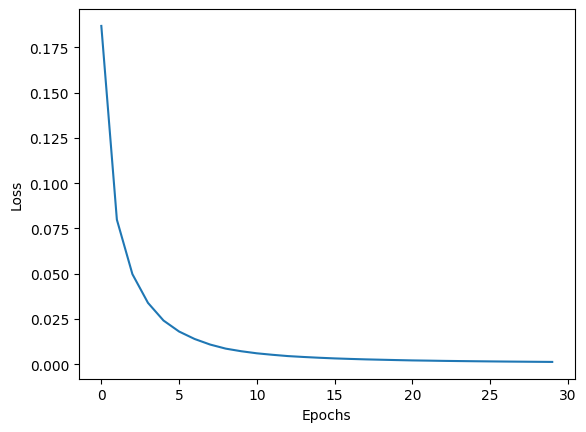


Hidden size= 250 --Total number of parameters: 261510  -- Test accuracy: 90.0 %


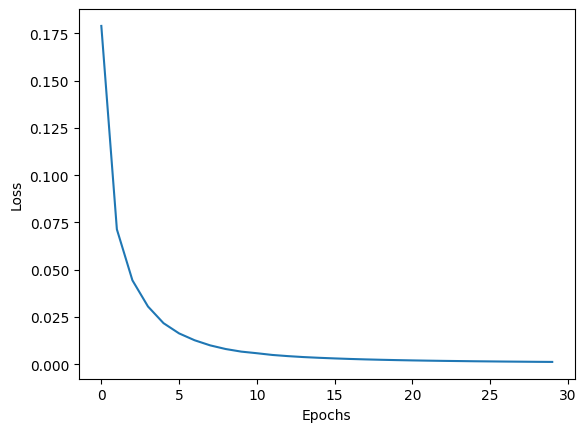


Hidden size= 300 --Total number of parameters: 328810  -- Test accuracy: 90.0 %


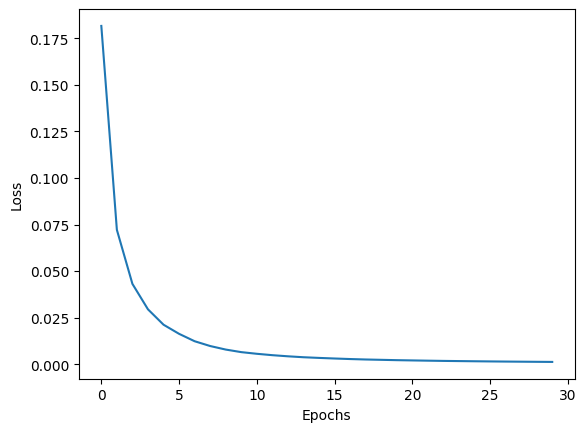


Hidden size= 400 --Total number of parameters: 478410  -- Test accuracy: 86.0 %


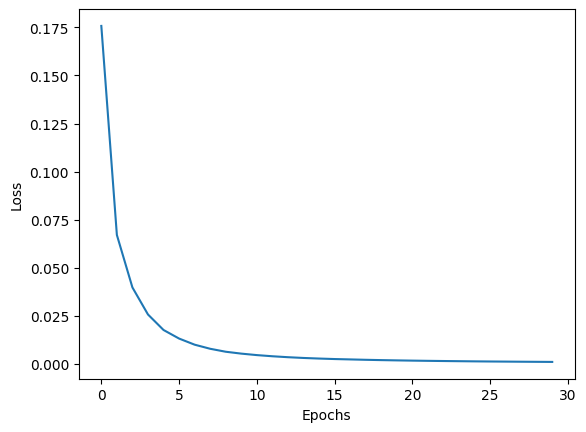

In [193]:
# TO DO: define, train and evalute an MLP classifier model with a variable hidden_size:
# - 'hidden_size' ranges in [5, 10, 100, 200]
hidden_sizes = [5, 10, 100, 200,250,300,400]
for hidden_size in hidden_sizes:
    model = MLPClassif(input_size, hidden_size, num_classes, nn.ReLU())
    torch.manual_seed(0)
    model.apply(init_weights)
    model, trainlosses = training_mlp_classifier(model,train_dataloader,num_epochs, loss_fn, learning_rate, verbose=True)
    eval = eval_mlp_classifier(model,test_dataloader)
    print()
    print('Hidden size=', hidden_size, '--Total number of parameters:', sum(p.numel() for p in model.parameters()),
          ' -- Test accuracy:', eval, '%')
    plt.figure()
    plt.plot(trainlosses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    # print(model_tr.state_dict())
# - the networks use ReLU activation, and training uses 30 epochs
# - for each hidden size, print the number of parameters and the test accuracy
# Remember to initialize the weights of the network after instanciating it for reproducibility.


<span style="color:red">**Q4**</span> Report the test accuracy as a function of `hidden_size`. Which value of `hidden_size` would you use and why?